# 第9章: RNN, CNN

## 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に`1`，2番目に頻出する単語に`2`，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて`0`とせよ．

In [1]:
!ls Output/Chapter06/*.feature.txt

Output/Chapter06/test.feature.txt   Output/Chapter06/valid.feature.txt
Output/Chapter06/train.feature.txt


In [2]:
from operator import itemgetter

In [3]:
def create_word2count():
    word2count = {}
    once_words = set()

    def _create_word2count_file(f):
        for line in f:
            words = line.replace("\n", "").split("\t")[1].split()
            for word in words:
                if word in word2count:
                    word2count[word] += 1
                elif word in once_words:
                    word2count[word] = 2
                    once_words.remove(word)
                else:
                    once_words.add(word)

    with open("Output/Chapter06/train.feature.txt") as f:
        _create_word2count_file(f)

    with open("Output/Chapter06/valid.feature.txt") as f:
        _create_word2count_file(f)

    with open("Output/Chapter06/test.feature.txt") as f:
        _create_word2count_file(f)

    word2count_sorted = sorted(word2count.items(), reverse=True, key=itemgetter(1,0))
    return {k: v for k, v in word2count_sorted}

In [4]:
word2count = create_word2count()

In [5]:
def sentence2ids(sentence: str):
    return [list(word2count.keys()).index(word) + 1 if word in word2count else 0
            for word in sentence.split()]

In [6]:
# Test
sentence2ids("updat 2-at&t threaten sit US spectrum auction rule")

[3, 0, 999, 2390, 5, 6330, 1098, 163]

## 81. RNNによる予測
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．再帰型ニューラルネットワーク（RNN: Recurrent Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルとして，次式を実装せよ．
$$
\overrightarrow{h}_0 = 0, \overrightarrow{h}_t = \overrightarrow{\mathrm{RNN}}(\mathrm{emb}(x_t), \overrightarrow{h}_{t-1}), y = \mathrm{softmax}(W^{(yh)} \overrightarrow{h}_T + b^{(y)})
$$
ただし，$\mathrm{emb}(x) \in \mathbb{R}^{d_w}$は単語埋め込み（単語のone-hot表記から単語ベクトルに変換する関数），$\overrightarrow{h}_t \in \mathbb{R}^{d_h}$は時刻$t$の隠れ状態ベクトル，$\overrightarrow{\mathrm{RNN}}(x,h)$は入力$x$と前時刻の隠れ状態$h$から次状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である（$d_w, d_h, L$はそれぞれ，単語埋め込みの次元数，隠れ状態ベクトルの次元数，ラベル数である）．RNNユニット$\overrightarrow{\mathrm{RNN}}(x,h)$には様々な構成が考えられるが，典型例として次式が挙げられる．
$$
\overrightarrow{\mathrm{RNN}}(x,h) = g(W^{(hx)} x + W^{(hh)}h + b^{(h)})
$$
ただし，$W^{(hx)} \in \mathbb{R}^{d_h \times d_w}，W^{(hh)} \in \mathbb{R}^{d_h \times d_h}, b^{(h)} \in \mathbb{R}^{d_h}$はRNNユニットのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど）である．

なお，この問題ではパラメータの学習を行わず，ランダムに初期化されたパラメータで$y$を計算するだけでよい．次元数などのハイパーパラメータは，$d_w = 300, d_h=50$など，適当な値に設定せよ（以降の問題でも同様である）．

In [7]:
import numpy as np
import random
import torch

In [8]:
random.seed(81)
np.random.seed(81)
torch.manual_seed(81)

In [9]:
labels = ["b", "t", "e", "m"]
V = len(word2count) + 1 # +1は出現回数1回のID番号0の分を追加している
d_w = 300
d_h = 50
V

8698

In [10]:
class NewsAggregatorDataset81(torch.utils.data.Dataset):
    def __init__(self, type_str: str):
        if type_str not in ["train", "valid", "test"]:
            raise ValueError("Invalid type_str:%s" % type_str)

        in_path = "Output/Chapter06/%s.feature.txt" % type_str
        self.x_data, self.y_data = [], []

        with open(in_path) as f:
            for line in f:
                elements = line.replace("\n", "").split("\t")
                self.x_data.append(torch.tensor(sentence2ids(elements[1]),
                                                dtype=torch.int64))
                self.y_data.append(torch.tensor(labels.index(elements[0]),
                                                dtype=torch.int64))

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [11]:
%%time
dataset81_train = NewsAggregatorDataset81("train")
dataset81_valid = NewsAggregatorDataset81("valid")
dataset81_test = NewsAggregatorDataset81("test")

CPU times: user 9.64 s, sys: 28.6 ms, total: 9.67 s
Wall time: 9.65 s


In [12]:
class Network81(torch.nn.Module):
    def __init__(self):
        super(Network81, self).__init__()

        # (batch,T,V) -> (batch,T,d_w)
        self.emb = torch.nn.Embedding(num_embeddings=V,
                                      embedding_dim=d_w)
        # (batch,T,d_w), (batch,1,d_h) -> (batch,T,d_h), (batch,1,d_h)
        self.rnn = torch.nn.RNN(input_size=d_w,
                                hidden_size=d_h,
                                batch_first=True)
        # (batch,d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, h0):
        # (batch,T) -> (batch,T,d_w)
        x = self.emb(x)
        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        _, hn = self.rnn(x, h0)
        # (1,batch,d_h) -> (batch,d_h)
        hn = torch.squeeze(hn, 0)
        # (batch,d_h) -> (batch,4)
        x = self.affine(hn)
        return self.log_softmax(x)

In [13]:
network81 = Network81()

In [16]:
for x_in, _ in torch.utils.data.DataLoader(dataset81_test, batch_size=1):
    h0 = torch.zeros(1, 1, d_h)
    x_out = network81(x_in, h0)
    y = torch.exp(x_out)
    print(y)
    break

tensor([[0.3053, 0.2050, 0.3143, 0.1754]], grad_fn=<ExpBackward>)


## 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [18]:
random.seed(82)
np.random.seed(82)
torch.manual_seed(82)

In [19]:
%matplotlib inline

In [20]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [21]:
network82, epoch, lr = Network81(), 10, 0.05
loader82_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=1,
                                             shuffle=True)
loader82_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [22]:
%%time
result82 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network82.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader82_train:
        network82.zero_grad()
        h0 = torch.zeros(1, 1, d_h)
        x_out = network82(x_in, h0)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result82["Epoch"].append(e)
    result82["Type"].append("Training")
    result82["Loss"].append(loss_sum)
    result82["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader82_valid:
        network82.zero_grad()
        h0 = torch.zeros(1, 1, d_h)
        x_out = network82(x_in, h0)
        loss = criterion(x_out, y)

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result82["Epoch"].append(e)
    result82["Type"].append("Validation")
    result82["Loss"].append(loss_sum)
    result82["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/10,Loss:1677.313,Training Accuracy:53.00%,Validation Accuracy:62.50%
Epoch:2/10,Loss:1832.675,Training Accuracy:57.66%,Validation Accuracy:59.51%
Epoch:3/10,Loss:2100.950,Training Accuracy:60.35%,Validation Accuracy:42.22%
Epoch:4/10,Loss:1578.757,Training Accuracy:61.42%,Validation Accuracy:63.55%
Epoch:5/10,Loss:1690.090,Training Accuracy:61.39%,Validation Accuracy:60.55%
Epoch:6/10,Loss:1792.233,Training Accuracy:62.51%,Validation Accuracy:59.06%
Epoch:7/10,Loss:1791.270,Training Accuracy:60.12%,Validation Accuracy:63.17%
Epoch:8/10,Loss:1939.560,Training Accuracy:59.01%,Validation Accuracy:58.83%
Epoch:9/10,Loss:1784.198,Training Accuracy:59.59%,Validation Accuracy:53.07%
Epoch:10/10,Loss:1907.828,Training Accuracy:59.37%,Validation Accuracy:51.80%
CPU times: user 9min 21s, sys: 4.08 s, total: 9min 25s
Wall time: 9min 23s


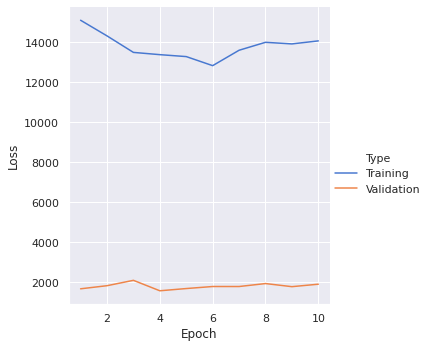

In [23]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result82))

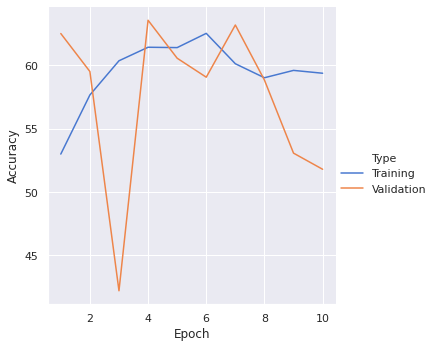

In [24]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result82))

## 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，$B$事例ごとに損失・勾配を計算して学習を行えるようにせよ（$B$の値は適当に選べ）．また，GPU上で学習を実行せよ．

In [25]:
torch.cuda.is_available()

True

In [26]:
random.seed(83)
np.random.seed(83)
torch.manual_seed(83)
if torch.cuda.is_available():
    torch.cuda.manual_seed(83)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
def news_aggregator_collate_fn(batch):
    x_batch = torch.nn.utils.rnn.pad_sequence([b[0] for b in batch],
                                              batch_first=True)
    y_batch = torch.tensor([b[1] for b in batch], dtype=torch.int64)

    return x_batch, y_batch

In [28]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [29]:
network83, epoch, batch_size, lr = Network81().to(device), 30, 32, 0.05
loader83_train = torch.utils.data.DataLoader(dataset81_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader83_valid = torch.utils.data.DataLoader(dataset81_valid,
                                             batch_size=1,
                                             shuffle=True)

In [30]:
%%time
result83 = {"Epoch" : [],
            "Type" : [],
            "Loss" : [],
            "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network83.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader83_train:
        network83.zero_grad()
        h0 = torch.zeros(1, x_in.shape[0], d_h).to(device)
        x_out = network83(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset81_train)
    result83["Epoch"].append(e)
    result83["Type"].append("Training")
    result83["Loss"].append(loss_sum)
    result83["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader83_valid:
        network83.zero_grad()
        h0 = torch.zeros(1, 1, d_h).to(device)
        x_out = network83(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset81_valid)
    result83["Epoch"].append(e)
    result83["Type"].append("Validation")
    result83["Loss"].append(loss_sum)
    result83["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/30,Loss:1801.138,Training Accuracy:46.13%,Validation Accuracy:34.88%
Epoch:2/30,Loss:1793.971,Training Accuracy:50.86%,Validation Accuracy:36.23%
Epoch:3/30,Loss:1734.103,Training Accuracy:51.43%,Validation Accuracy:41.54%
Epoch:4/30,Loss:1750.406,Training Accuracy:53.84%,Validation Accuracy:43.04%
Epoch:5/30,Loss:1756.773,Training Accuracy:47.81%,Validation Accuracy:50.30%
Epoch:6/30,Loss:1458.255,Training Accuracy:51.57%,Validation Accuracy:62.65%
Epoch:7/30,Loss:1495.398,Training Accuracy:53.25%,Validation Accuracy:57.63%
Epoch:8/30,Loss:1527.637,Training Accuracy:48.63%,Validation Accuracy:56.66%
Epoch:9/30,Loss:1465.028,Training Accuracy:51.18%,Validation Accuracy:61.15%
Epoch:10/30,Loss:1522.287,Training Accuracy:54.65%,Validation Accuracy:58.98%
Epoch:11/30,Loss:1408.543,Training Accuracy:45.96%,Validation Accuracy:64.90%
Epoch:12/30,Loss:1793.147,Training Accuracy:51.17%,Validation Accuracy:48.73%
Epoch:13/30,Loss:1727.668,Training Accuracy:48.24%,Validation Accuracy:52

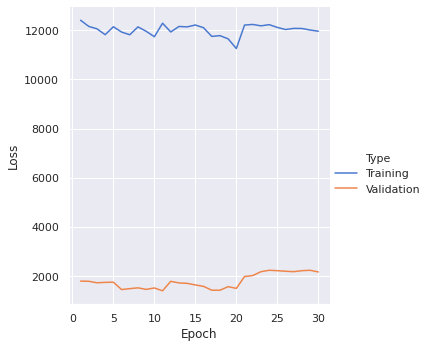

In [31]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result83))

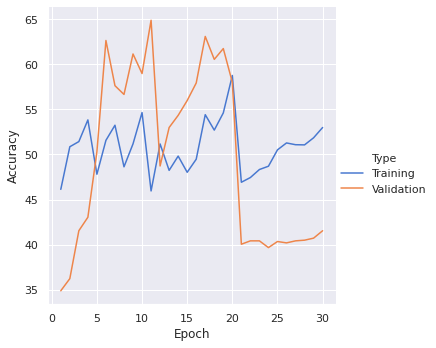

In [32]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result83))

## 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)）で単語埋め込み$\mathrm{emb}(x)$を初期化し，学習せよ．

In [1]:
!ls Input/GoogleNews-vectors-negative300.bin

Input/GoogleNews-vectors-negative300.bin


In [14]:
!ls Output/Chapter06/*.txt | grep -v feature

Output/Chapter06/test.txt
Output/Chapter06/train.txt
Output/Chapter06/valid.txt


In [2]:
from gensim.models.keyedvectors import KeyedVectors

In [3]:
%%time
wv = KeyedVectors.load_word2vec_format("Input/GoogleNews-vectors-negative300.bin", binary=True)

CPU times: user 17.1 s, sys: 4.09 s, total: 21.2 s
Wall time: 31.1 s


In [34]:
random.seed(84)
np.random.seed(84)
torch.manual_seed(84)
if torch.cuda.is_available():
    torch.cuda.manual_seed(84)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [43]:
class NewsAggregatorDataset84(torch.utils.data.Dataset):
    def __init__(self, type_str: str):
        if type_str not in ["train", "valid", "test"]:
            raise ValueError("Invalid type_str:%s" % type_str)

        in_path = "Output/Chapter06/%s.txt" % type_str
        self.x_data, self.y_data = [], []

        with open(in_path) as f:
            for line in f:
                elements = line.replace("\n", "").split("\t")
                self.x_data.append(torch.tensor([wv[word] if word in wv else np.zeros(300)
                                                 for word in elements[1].split()],
                                                dtype=torch.float32))
                self.y_data.append(torch.tensor(labels.index(elements[0]),
                                                dtype=torch.int64))

    def __len__(self):
        return len(self.y_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [44]:
%%time
dataset84_train = NewsAggregatorDataset84("train")
dataset84_valid = NewsAggregatorDataset84("valid")
dataset84_test = NewsAggregatorDataset84("test")

CPU times: user 4.52 s, sys: 5.92 ms, total: 4.52 s
Wall time: 4.52 s


In [45]:
class Network84(torch.nn.Module):
    def __init__(self):
        super(Network84, self).__init__()

        # (batch,T,d_w), (batch,1,d_h) -> (batch,T,d_h), (batch,1,d_h)
        self.rnn = torch.nn.RNN(input_size=d_w,
                                hidden_size=d_h,
                                batch_first=True)
        # (batch,d_h) -> (batch,4)
        self.affine = torch.nn.Linear(in_features=d_h,
                                      out_features=4)
        self.log_softmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x, h0):
        # (batch,T,d_w), (1,batch,d_h) -> (batch,T,d_h), (1,batch,d_h)
        _, hn = self.rnn(x, h0)
        # (1,batch,d_h) -> (batch,d_h)
        hn = torch.squeeze(hn, 0)
        # (batch,d_h) -> (batch,4)
        x = self.affine(hn)
        return self.log_softmax(x)

In [48]:
network84, epoch, batch_size, lr = Network84().to(device), 30, 32, 0.05
loader84_train = torch.utils.data.DataLoader(dataset84_train,
                                             batch_size=batch_size,
                                             collate_fn=news_aggregator_collate_fn,
                                             shuffle=True)
loader84_valid = torch.utils.data.DataLoader(dataset84_valid,
                                             batch_size=1,
                                             shuffle=True)

In [49]:
%%time
result_84 = {"Epoch" : [],
             "Type" : [],
             "Loss" : [],
             "Accuracy" : []}

for e in range(1, epoch+1):
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.SGD(network84.parameters(), lr=lr)
    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader84_train:
        network.zero_grad()
        h0 = torch.zeros(1, x_in.shape[0], d_h).to(device)
        x_out = network84(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_train = 100.0 * correct_sum / len(dataset84_train)
    result_84["Epoch"].append(e)
    result_84["Type"].append("Training")
    result_84["Loss"].append(loss_sum)
    result_84["Accuracy"].append(accuracy_train)

    loss_sum, correct_sum = 0.0, 0

    for x_in, y in loader84_valid:
        network84.zero_grad()
        h0 = torch.zeros(1, 1, d_h).to(device)
        x_out = network84(x_in.to(device), h0)
        loss = criterion(x_out, y.to(device))

        loss_sum += loss.item() * x_in.shape[0]
        x_pred = torch.argmax(x_out, dim=1)
        correct_sum += int(torch.sum(x_pred==y.to(device)))

    accuracy_valid = 100.0 * correct_sum / len(dataset84_valid)
    result_84["Epoch"].append(e)
    result_84["Type"].append("Validation")
    result_84["Loss"].append(loss_sum)
    result_84["Accuracy"].append(accuracy_valid)

    args = (e, epoch, loss_sum, accuracy_train, accuracy_valid)
    print_str = "Epoch:%d/%d,Loss:%.3f,Training Accuracy:%.2f%%,Validation Accuracy:%.2f%%"
    print(print_str % args)

Epoch:1/30,Loss:4408.282,Training Accuracy:38.01%,Validation Accuracy:39.30%
Epoch:2/30,Loss:17044.000,Training Accuracy:34.15%,Validation Accuracy:39.30%
Epoch:3/30,Loss:49398.310,Training Accuracy:35.70%,Validation Accuracy:12.28%
Epoch:4/30,Loss:57748.871,Training Accuracy:34.92%,Validation Accuracy:42.66%
Epoch:5/30,Loss:24319.877,Training Accuracy:34.98%,Validation Accuracy:42.66%
Epoch:6/30,Loss:22766.143,Training Accuracy:34.63%,Validation Accuracy:42.66%
Epoch:7/30,Loss:41736.304,Training Accuracy:34.85%,Validation Accuracy:39.30%
Epoch:8/30,Loss:83783.026,Training Accuracy:34.83%,Validation Accuracy:42.66%
Epoch:9/30,Loss:75968.223,Training Accuracy:35.06%,Validation Accuracy:12.20%
Epoch:10/30,Loss:55372.136,Training Accuracy:35.26%,Validation Accuracy:39.30%
Epoch:11/30,Loss:46965.002,Training Accuracy:35.37%,Validation Accuracy:39.30%
Epoch:12/30,Loss:35066.731,Training Accuracy:35.39%,Validation Accuracy:39.30%
Epoch:13/30,Loss:11337.847,Training Accuracy:35.41%,Validation

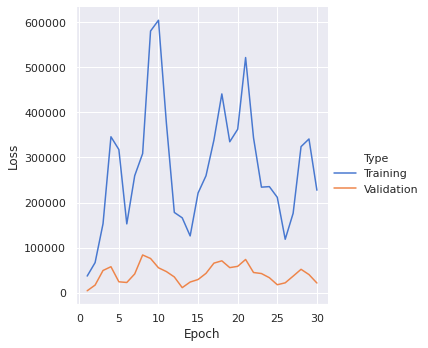

In [56]:
sns.relplot(x="Epoch",
            y="Loss",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result_84))

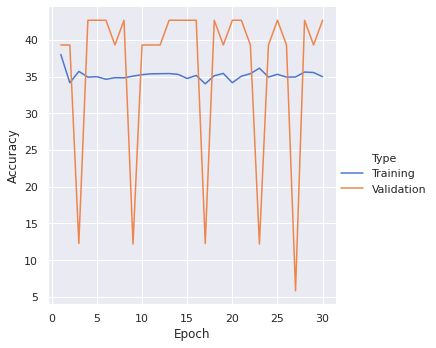

In [57]:
sns.relplot(x="Epoch",
            y="Accuracy",
            hue="Type",
            kind="line",
            data=pd.DataFrame(result_84))

## 85. 双方向RNN・多層化
順方向と逆方向のRNNの両方を用いて入力テキストをエンコードし，モデルを学習せよ．
$$
\overleftarrow{h}_{T+1} = 0, \overleftarrow{h}_t = \overleftarrow{\mathrm{RNN}}(\mathrm{emb}(x_t), \overleftarrow{h}_{t+1}), y = \mathrm{softmax}(W^{(yh)} [\overrightarrow{h}_T; \overleftarrow{h}_1] + b^{(y)})
$$
ただし，$\overrightarrow{h}_t \in \mathbb{R}^{d_h}, \overleftarrow{h}_t \in \mathbb{R}^{d_h}$はそれぞれ，順方向および逆方向のRNNで求めた時刻$t$の隠れ状態ベクトル，$\overleftarrow{\mathrm{RNN}}(x,h)$は入力$x$と次時刻の隠れ状態$h$から前状態を計算するRNNユニット，$W^{(yh)} \in \mathbb{R}^{L \times 2d_h}$は隠れ状態ベクトルからカテゴリを予測するための行列，$b^{(y)} \in \mathbb{R}^{L}$はバイアス項である．また，$[a; b]$はベクトル$a$と$b$の連結を表す。

さらに，双方向RNNを多層化して実験せよ．

## 86. 畳み込みニューラルネットワーク (CNN)
ID番号で表現された単語列$\boldsymbol{x} = (x_1, x_2, \dots, x_T)$がある．ただし，$T$は単語列の長さ，$x_t \in \mathbb{R}^{V}$は単語のID番号のone-hot表記である（$V$は単語の総数である）．畳み込みニューラルネットワーク（CNN: Convolutional Neural Network）を用い，単語列$\boldsymbol{x}$からカテゴリ$y$を予測するモデルを実装せよ．

ただし，畳み込みニューラルネットワークの構成は以下の通りとする．
+ 単語埋め込みの次元数: $d_w$
+ 畳み込みのフィルターのサイズ: 3 トークン
+ 畳み込みのストライド: 1 トークン
+ 畳み込みのパディング: あり
+ 畳み込み演算後の各時刻のベクトルの次元数: $d_h$
+ 畳み込み演算後に最大値プーリング（max pooling）を適用し，入力文を$d_h$次元の隠れベクトルで表現

すなわち，時刻$t$の特徴ベクトル$p_t \in \mathbb{R}^{d_h}$は次式で表される．
$$
p_t = g(W^{(px)} [\mathrm{emb}(x_{t-1}); \mathrm{emb}(x_t); \mathrm{emb}(x_{t+1})] + b^{(p)})
$$
ただし，$W^{(px)} \in \mathbb{R}^{d_h \times 3d_w}, b^{(p)} \in \mathbb{R}^{d_h}$はCNNのパラメータ，$g$は活性化関数（例えば$\tanh$やReLUなど），$[a; b; c]$はベクトル$a, b, c$の連結である．なお，行列$W^{(px)}$の列数が$3d_w$になるのは，3個のトークンの単語埋め込みを連結したものに対して，線形変換を行うためである．

最大値プーリングでは，特徴ベクトルの次元毎に全時刻における最大値を取り，入力文書の特徴ベクトル$c \in \mathbb{R}^{d_h}$を求める．$c[i]$でベクトル$c$の$i$番目の次元の値を表すことにすると，最大値プーリングは次式で表される．
$$
c[i] = \max_{1 \leq t \leq T} p_t[i]
$$
最後に，入力文書の特徴ベクトル$c$に行列$W^{(yc)} \in \mathbb{R}^{L \times d_h}$とバイアス項$b^{(y)} \in \mathbb{R}^{L}$による線形変換とソフトマックス関数を適用し，カテゴリ$y$を予測する．
$$
y = \mathrm{softmax}(W^{(yc)} c + b^{(y)})
$$
なお，この問題ではモデルの学習を行わず，ランダムに初期化された重み行列で$y$を計算するだけでよい．

## 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

## 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．

## 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えば[BERT](https://github.com/google-research/bert)など）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．